# Projeto Final de Aprendizado de Máquina

#### Duplas: Aliança BA-AL e Nemphis & Nempharey

#### Integrantes: Davi J.A. Pereira, Diogo P. de L. Carvalho, Mayllon E.P.S. Silva, Samuel S. de Araújo

## Notebook 2: Baseline, Árvore de Decisão e Floresta Aleatória

## Introdução

<p style="text-align: justify"> Neste notebook, os modelos de Machine Leaning <b><i>baseline</i></b>, <b>árvore de decisão</b> e <b>floresta aleatória</b> foram testados no dataset de supercondutores após a aplicação do método fator de inflação de variância (VIF) a partir de validação cruzada $k$-fold, havendo a temperatura crítica como target. Em nenhum modelo, foram utilizados dados normalizados, uma vez que normalizar ou não os dados não influencia nos modelos utilizados neste caderno. Além disso, é imprescindível ressaltar que foi utilizado um algortimo de otimização de hiperparâmetros para os modeos de árvore de decisão e floresta aleátoria, sendo utilizado a divisão do dataset em dados de treino e teste neste algoritmo. Para testar a performance dos modelos, utilizou-se as métricas RMSE, MAE e R<sup>2</sup>.

### Bibliotecas e Funções Utilizadas

<p style="text-align: justify"> Neste caderno, importou-se as bibliotecas <code>pandas</code>, <code>matplotlib.pyplot</code>, <code>numpy</code> e <code>pickle</code>, as quais foram utilizadas ao longo deste notebook. Além disso, também se utilizou funções, classes, módulos e métricas da biblioteca <code>scikit-learn</code>, os quais foram, assim como as bibliotecas citadas, importados abaixo:

In [310]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from optuna import create_study, Trial
from sklearn import tree
from sklearn.metrics import SCORERS

### Métricas e Constantes Utilizadas

<p style="text-align: justify"> Neste notebook, utilizou-se as métricas RMSE, MAE e R<sup>2</sup>, as quais foram explicadas no notebook 1 <sup>[1]</sup>. Tais métricas foram utilizadas diretamente na função de validação cruzada <code>cross_validate()</code> da biblioteca <code>scikit-learn</code>, a qual aceita mais de uma métrica ao realizar a validação cruzada <sup>[2, 3]</sup>. Todas as métricas que podem ser utilizadas pela função citada podem ser visualizadas a partir do dicionário <code>sklearn.metrics.SCORERS</code>, observe:

In [311]:
print(SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

<p style="text-align: justify"> As métricas utilizadas foram delcaradas no dicionário <code>METRICS</code>, sendo as chaves os nomes usuais para as métricas, e os respectivos valores o string associado à métrica pela função <code>cross_validate()</code>. Além disso, ao longo do caderno, utilizou-se três constantes, o <code>NUM_FOLDS</code> como o número de iterações sendo 10 ($k$ = 10) para a validação cruzada $k$-fold, o <code>TAMANHO_TESTE</code> como a quantidade de dados utilizados como teste na divisão dos dados para teste e para treino para 0.1 (10% do total de dados), e a <code>SEMENTE_ALEATORIA</code> como o valor da seed como 0 para a reprodutibilidade de certos processos. A biblioteca contendo as métricas e as constantes podem ser visualizadas abaixo.

In [3]:
METRICS = {
    "RMSE": "neg_root_mean_squared_error",
    "MAE": "neg_mean_absolute_error", 
    "R2": "r2"
}

NUM_FOLDS = 10
TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 0

### Ajustanto o Dataset Para Utilização Neste Caderno

<p style="text-align: justify"> Para testar os modelos, utilizou-se o dataset após a aplicação do fator de inflação da variância (VIF) <sup>[1]</sup>. Para isso, o arquivo em csv contendo os dados foi importado abaixo como um DataFrame, sendo o <code>X</code> declarado como os 29 atributos utilizados e <code>y</code> como o target utilizado. 

In [4]:
# Importando o dataset após aplicação do VIF como um DataFrame.
dataset_VIF = pd.DataFrame(pd.read_csv('Dataset_superoncondutores_2.csv'))

list_one = np.array(dataset_VIF.columns)
features = np.array(list_one[:-1]) # Definindo features como todos os atributos, com exceção do último: a temperatura crítica.
target = ["critical_temp"] # Definindo o target como a temperatura crítica

X = dataset_VIF[features] # Declarando X como os dados com os 29 atributos.
X

,mean_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,gmean_fie,wtd_range_fie,mean_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_entropy_Density,range_Density,...,wtd_std_FusionHeat,mean_ThermalConductivity,wtd_gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,wtd_range_ThermalConductivity,gmean_Valence,range_Valence,wtd_range_Valence,wtd_std_Valence
0,88.944468,31.794921,51.968828,718.152900,735.985714,160.250000,42.914286,75.237540,0.814598,8958.571,...,4.666920,107.756645,0.621979,0.308148,0.262848,57.127669,2.213364,1,1.085714,0.437059
1,92.729214,36.161939,47.094633,720.605511,743.164286,161.200000,50.571429,67.321319,0.914802,10488.571,...,4.603000,172.205316,0.619735,0.847404,0.567706,51.413383,1.888175,2,1.128571,0.468606
2,88.944468,35.741099,51.968828,718.152900,743.164286,160.250000,49.314286,75.237540,0.760305,8958.571,...,4.649635,107.756645,0.619095,0.308148,0.250477,57.127669,2.213364,1,1.114286,0.444697
3,88.944468,33.768010,51.968828,718.152900,739.575000,160.250000,46.114286,75.237540,0.788889,8958.571,...,4.658301,107.756645,0.620535,0.308148,0.257045,57.127669,2.213364,1,1.100000,0.440952
4,88.944468,27.848743,51.968828,718.152900,728.807143,160.250000,36.514286,75.237540,0.859811,8958.571,...,4.684014,107.756645,0.624878,0.308148,0.272820,57.127669,2.213364,1,1.057143,0.428809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21258,106.957877,15.504479,65.764081,651.611213,427.546667,176.500000,57.808889,45.883003,1.110551,7511.000,...,17.657417,65.500000,95.001493,1.029002,0.634332,83.048889,3.223710,1,2.168889,0.496904
21259,92.266740,7.353333,69.232655,702.115184,659.771429,159.200000,20.285714,67.211309,1.080432,11848.571,...,5.204855,132.805316,1.577047,0.949904,0.745515,76.176553,2.168944,1,0.904762,0.212959
21260,99.663190,53.041104,6.756810,730.207231,370.180000,183.500000,124.600000,14.500000,0.572700,3453.000,...,4.040000,62.500000,57.038314,0.683870,0.559446,29.000000,4.472136,1,3.200000,0.400000
21261,99.663190,31.115202,6.756810,730.207231,208.799000,183.500000,84.230000,14.500000,0.667210,3453.000,...,4.671182,62.500000,58.781651,0.683870,0.659671,15.250000,4.472136,1,2.210000,0.462493


In [5]:
y = dataset_VIF[target] # Declarando y como o target.
y

,critical_temp
0,29.00
1,26.00
2,19.00
3,22.00
4,23.00
...,...
21258,2.44
21259,122.10
21260,1.98
21261,1.84


### Divisão de Dados de Treino e Teste

<p style="text-align: justify"> Embora haja sido utilizado a validação cruzada para a análise de perfomance dos modelos, realizou-se a divisão dos dados em treino e teste abaixo para que seja utilizado na otimização de hiperparâmetros dos modelos de <b>árvore de decisão</b> e <b>floresta aleatória</b> neste caderno de forma menos custosa que a validação cruzada com todos os dados. Para isso, utilizou-se a função <code>train_test_split</code> da biblioteca <code>scikit-learn</code>, sendo separado 90% dos dados como treino e 10% como teste. Para a elaboração do código, utilizou-se como base um código do professor Daniel Cassar <sup>[4]</sup>. 

In [6]:
# A separação foi realizada a partir dos índices do dataset.
indices = dataset_VIF.index 
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

# O dataset foi dividido dois DataFrames a partir dos índices, um com os dados de treino e outro com os dados de teste.
df_treino = dataset_VIF.loc[indices_treino] 
df_teste = dataset_VIF.loc[indices_teste]

# O DataFrame de treino foi dividido em dois, um com os atributos para treino e outro com o target para treino.
X_treino = df_treino.reindex(features, axis=1).values
y_treino = df_treino.reindex(target, axis=1).values.ravel()

# O DataFrame de treino foi dividido em dois, um com os atributos para teste e outro com o target para teste.
X_teste = df_teste.reindex(features, axis=1).values
y_teste = df_teste.reindex(target, axis=1).values.ravel()

### Otimização de Hiperparâmetros e Utilização de Cluster de Alta Performance (High Performance Computing - HPC) 

<p style="text-align: justify"> Como já mencionado anteriormente, foi utilizado otimização de hiperparâmetros para os modelos de <b>árvore de decisão</b> e o de <b>floresta aleatória</b> neste caderno. Para isso, a otimização foi realizada a partir do <code>optuna</code>, sendo utilizado um código do professor Daniel Cassar como base <sup>[5]</sup>, sendo realizado alteração apenas no dicionário de <code>parametros</code>. O algoritmo para a otimização utiliza três funções <code>cria_instancia_modelo(trial)</code>, <code>funcao_objetivo(trial, X, y, num_folds=NUM_FOLDS)</code> e <code>funcao_objetivo_parcial(trial)</code> <sup>[5]</sup>. 

<p style="text-align: justify"> A função <code>cria_instancia_modelo(trial)</code> cria uma instância do modelo escolhido, recebendo como a argumento um objeto de "tentativa" (<code>trial</code>) do <code>optuna</code>. Na função, há um dicionário <code>parametros</code>, em que há os hiperparâmetros do modelo que não necessariamente seguirão o valor padrão. Nesse dicionário, há os hiperparâmetros que irão variar de acordo com valores sugeridos a partir do <code>optuna</code> nas funções <code>trial.suggest_categorical</code> (para valores categórico), <code>trial.suggest_int</code> (para números inteiros) e <code>trial.suggest_float</code> (para números flutuantes) <sup>[5]</sup>.

<p style="text-align: justify"> A função <code>funcao_objetivo(trial, X, y, num_folds=NUM_FOLDS)</code> que é responsável por computar a métrica utilizada, no caso apenas o RMSE, do modelo suferido a partir da validação cruzada $k$-fold. Já a função <code>funcao_objetivo_parcial(trial)</code>, chama a função <code>funcao_objetivo(trial, X, y, num_folds=NUM_FOLDS)</code> a partir de apenas um argumento em vez de três. Após definir as funções citadas, para a otimização em si, declarou-se <code>objeto_de_estudo</code> como um objeto de estudo de minimização pelo <code>create_study</code>. Assim, pode-se rodar o otimizador <code>objeto_de_estudo</code> a partir do método de <code>optimize</code>, havendo a função <code>funcao_objetivo_parcial(trial)</code> como argumento e o número de modelos sugeridos criados pelo <code>optuna</code> <sup>[5]</sup>.

<p style="text-align: justify"> Nesse contexto, é imprescindível salientar que foi utilizado um cluser de alta perfomance (HPC) para rodar este notebook, uma vez que o processo de otimização de hiperparâmetros utilizado se demonstrou computacionalmente custoso para os modelos, principalmente para o modelo de floresta aleatória.

## Modelos de Regressão Linear

### Baseline

<p style="text-align: justify"> Um dos modelos mais simples existentes, é o <i>baseline</i>, também chamado de modelo base. Esse modelo se trata da previsão do valor de y, da temperatura crítica nesse caso, a partir de uma função constante. O modelo <i>baseline</i> pode ser descrito a partir do parâmetro <B>intercepto</B> do modelo $\beta_0$ e de uma <b>incerteza irredutível</b> $\epsilon$, também chamado de <b>termo do erro aleatório</B> <sup>[6]</sup>, observe: </p>

$$
y = \beta_0 + \epsilon.
$$

<p style="text-align: justify"> Devido a forma como o valor predito é determinado, o <code>baseline</code> retorna um mesmo valor predito para quaisquer dados de entrada. Dessarte, o <code>baseline</code> geralmente é utilizado apenas para analisar a performance de outros modelos, sendo qualquer modelo pior que esse considerado demasiado ruim <sup>[6]</sup>. A instância do modelo <code>baseline</code> no <code>scikit-learn</code> é o <code>DummyRegressor()</code> <sup>[7]</sup>.

<p style="text-align: justify"> Para exemplificar o modelo a partir do dataset, o modelo <code>baseline</code> foi aplicado nos atributos de média do raio atômico e de média da massa atômica, sendo plotado um gráfico com tais atributos e o <code>baseline</code> considerando apenas tais atributos. o target foi considerado a média do raio atômico, sendo a média da massa atômica como atributo. Abaixo, plotou-se apenas um gráfico com os dois atributos citados.

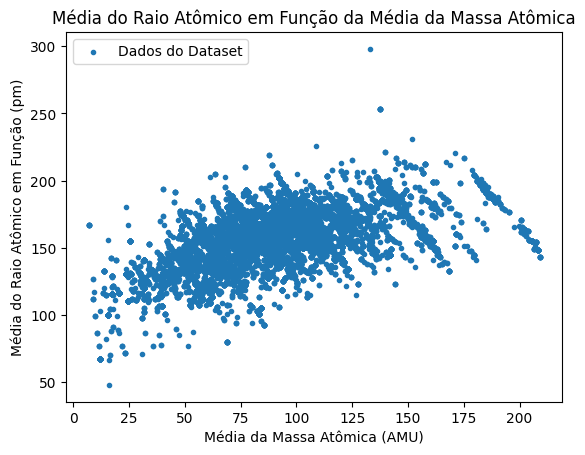

In [8]:
figura, eixo = plt.subplots() # Criação dos objetos 'figura' e 'eixo'.
eixo.scatter(data=X, x="mean_atomic_mass", y="mean_atomic_radius", marker = '.', label = "Dados do Dataset") # Os dados foram plotados como pontos.
eixo.set_title("Média do Raio Atômico em Função da Média da Massa Atômica") # Inserção do título.
eixo.set_xlabel("Média da Massa Atômica (AMU)") # Inserção da legenda do eixo x.
eixo.set_ylabel("Média do Raio Atômico em Função (pm)") # Inserção da legenda do eixo y.
eixo.legend(loc=2) # Inserção da legenda dos pontos.
plt.show() # Apenas o gráfico é exibido.

<p style="text-align: justify"> Já abaixo, aplicou-se o modelo e plotou o gráfico com o <i>baseline</i>:

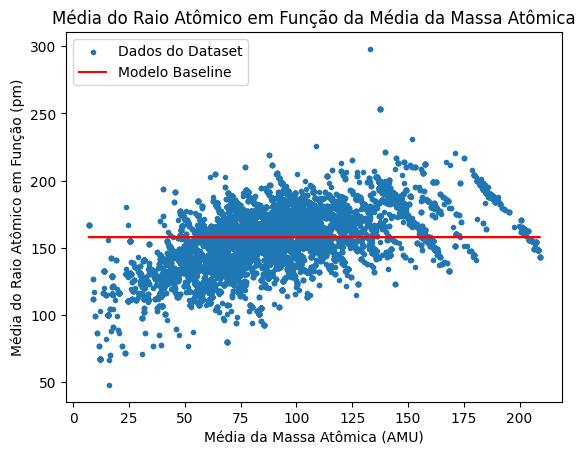

In [9]:
X_atomic_mass = X['mean_atomic_mass'].values.reshape(-1, 1) # Declarou-se a variável como o atributo de média da massa atômica como um matriz coluna.
y_atomic_radius = X['mean_atomic_radius'].values.reshape(-1, 1) # Declarou-se a variável como o atributo de média do rádio atômica como um matriz coluna.

modelo = DummyRegressor() # Declarou-se 'modelo' como instância do modelo baseline.
modelo.fit(X_atomic_mass, y_atomic_radius) # Treino do modelo.
y_predito = modelo.predict(X_atomic_mass) # Valores preditos do target, a média do raio atômico 

figura, eixo = plt.subplots() # Criação dos objetos 'figura' e 'eixo'.
eixo.scatter(data=X, x="mean_atomic_mass", y="mean_atomic_radius", marker = '.', label = "Dados do Dataset") # Os dados foram plotados como pontos.
eixo.plot(X["mean_atomic_mass"], y_predito, color='red', label="Modelo Baseline")
eixo.set_title("Média do Raio Atômico em Função da Média da Massa Atômica") # Inserção do título.
eixo.set_xlabel("Média da Massa Atômica (AMU)") # Inserção da legenda do eixo x.
eixo.set_ylabel("Média do Raio Atômico em Função (pm)") # Inserção da legenda do eixo y.
eixo.legend(loc=2) # Inserção da legenda dos pontos e da reta.
plt.show() # Apenas o gráfico é exibido.

<p style="text-align: justify"> Acima, observe que o modelo <code>baseline</code> possui um mecanismo de uma função constante, em que retorna o mesmo valor predito de $y$ (da média do raio atômico nesse caso) independente do valor de entrada (da média da massa atômica), sendo possível ver uma reta constante em $y$ como valor predito pelo modelo no gráfico.

<p style="text-align: justify"> Após essa breve explicação sobre o modelo <code>baseline</code>, esse será aplicado ao dataset como um todo.

In [10]:
modelo = DummyRegressor() # Uma instância do modelo baseline é criada.

# Realiza-se a validação cruzada com o modelo.
metricas = cross_validate(
    modelo,
    X,
    y,
    cv=NUM_FOLDS,
    scoring=METRICS,
)

# Determina-se o módulo das médias dos valores das iterações de cada métricas.
RMSE_DummyRegressor = abs(metricas["test_RMSE"]).mean()
MAE_DummyRegressor =  abs(metricas["test_MAE"]).mean()
R2_DummyRegressor =  abs(metricas["test_R2"]).mean()

# Os valores das médias das métricas são exibidos.
print(f'As métricas por validação cruzada pelo modelo baseline foram as seguintes:')
print(f'RMSE: {RMSE_DummyRegressor:0.4f} k;')
print(f'MAE: {MAE_DummyRegressor:0.4f} k;')
print(f'R2: {R2_DummyRegressor:0.4f} k.')

As métricas por validação cruzada pelo modelo baseline foram as seguintes:
RMSE: 35.5857 k;
MAE: 31.0000 k;
R2: 2.7405 k.


### Árvore de Decisão

<p style="text-align: justify"> As árvores de decisões são algoritmo baseados em decisões por nós (ou vértices) associados em uma determinada hierarquia  <sup>[8]</sup>. Assim, as árvores de decisões também podem classificadas como grafos direcionais acíclicos, sendo que os vértices (ou nós) podem ser classificados como raiz, de decisão ou folha <sup>[9]</sup>:

<ul>
    <li><b>Vértice raiz</b>: vértice cauda para dois vértices cabeça, o primeiro nó da árvore <sup>[9]</sup>;</li>
    <li><b>Vértice de decisão</b>: vértice cabeça para um vértice e cauda para dois vértices cabeça, sendo um nó intermediário da árvore <sup>[9]</sup>;</li>
    <li><b>Vértice folha</b>: vértice cabeça de um vértice, o último nó da árvore <sup>[9]</sup>.</li>
</ul>

<p style="text-align: justify"> Quando um nó possui um condicionado associado a um certo valor de um atributo, podendo retornar <code>True</code> (verdadeiro) ou <code>False</code> (falso)<sup>[8, 9]</sup>. Quando um exemplo é analisado por um nó e caso retorne o valor <code>True</code>, esse segue ao nó à esquerda abaixo do analizado; enquanto caso retorne <code>False</code>, o exemplo segue ao nó à direita abaixo do analizado.

<p style="text-align: justify"> No <code>scikit-learn</code>, a instâncida do modelo é <code>DecisionTreeRegressor()</code>, possuindo alguns hiperparâmetros imprescindíveis:

<ul>
    <li><b>criterion</b>: critério utilizado para medir a qualidade de uma divisão entre <i>squared_error, friedman_mse, absolute_error</i> e <i>poisson</i>, sendo o <i>squared_error</i> o valor padrão <sup>[10]</sup>;</li>
    <li><b>splitter</b>: estratégia utilizada para escolher a divisão em cada nó, podendo ser <i>best</i> para escolher a melhor divisão ou <i>random</i> para escolher a melhor divisão aleatória, sendo o valor padrão <i>best</i> <sup>[10]</sup>;</li>
    <li><b>max_leaf_nodes</b>: número máximo de vértices folha permitidos na árvore de decisão, possuindo o valor padrão de <code>None</code>, sem limite para tal número <sup>[9, 10]</sup>;</li>
    <li><b>max_depth</b>: profundidade máxima da árvore de decisão, sendo a profundidade de um vértice o número mínimo de vértices até se chegar ao vértice raiz. O valor padrão de profundaide é <code>None</code>, sem limite para esse número <sup>[9, 10]</sup>;</li>
    <li><b>min_samples_split</b>: número mínimo de exemplos necessários para um vértice não ser um vértice folha, sendo o valor padrão 2 <sup>[9, 10]</sup>;</li>
    <li><b>min_samples_leaf</b>: número mínimo de exemplos permitidos para um vértice folha, sendo o valor padrão 1 <sup>[9, 10]</sup>;</li>
    <li><b>max_features</b>: número de atributos considerados para a melhor divisão de um nó, sendo o valor padrão 1 (todos atributos) <sup>[10]</sup>.</li>
</ul>

<p style="text-align: justify"> Abaixo, utilizou-se a otimização de hiperparâmetros já explicada para determinar bons parâmetros para o modelo de árvore de decisão nos dataset:

In [26]:
def cria_instancia_modelo(trial):
    """Cria uma instância do modelo.

    Args:
      trial: objeto tipo Trial do optuna.

    Returns:
      Uma instância do modelo desejado.
    """

    parametros = {

        "criterion": trial.suggest_categorical("criterion", ["squared_error", "friedman_mse", "poisson"]),

        "splitter": trial.suggest_categorical("splitter", ["best", "random"]),

        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20, log=True),

        "max_depth": trial.suggest_int("max_depth", 1, 100, log=True),

        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20, log=True),

        "max_features": trial.suggest_float("max_features_internal", 0, 1),

        "random_state": SEMENTE_ALEATORIA,
    }

    model = DecisionTreeRegressor(**parametros)

    return model


def funcao_objetivo(
    trial,
    X,
    y,
    num_folds=NUM_FOLDS,
):
    """Função objetivo do optuna

    Referencia [11]:
      https://medium.com/@walter_sperat/using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451
    """

    modelo = cria_instancia_modelo(trial)

    metricas = cross_val_score(
        modelo,
        X,
        y,
        scoring="neg_root_mean_squared_error",
        cv=NUM_FOLDS,
    )

    return -metricas.mean()

objeto_de_estudo = create_study(direction="minimize")

def funcao_objetivo_parcial(trial):
    return funcao_objetivo(trial, X_treino, y_treino)

[I 2023-11-15 23:47:26,403] A new study created in memory with name: no-name-9302f4cb-32dd-444d-8544-d543e9d706f6


In [27]:
objeto_de_estudo.optimize(funcao_objetivo_parcial, n_trials=101)

[I 2023-11-15 23:47:26,931] Trial 0 finished with value: 15.95797207601916 and parameters: {'criterion': 'friedman_mse', 'splitter': 'random', 'min_samples_split': 8, 'max_depth': 12, 'min_samples_leaf': 9, 'max_features_internal': 0.32005474502228304}. Best is trial 0 with value: 15.95797207601916.
[I 2023-11-15 23:47:27,933] Trial 1 finished with value: 18.884854830991706 and parameters: {'criterion': 'poisson', 'splitter': 'best', 'min_samples_split': 3, 'max_depth': 5, 'min_samples_leaf': 16, 'max_features_internal': 0.4798393793992566}. Best is trial 0 with value: 15.95797207601916.
[I 2023-11-15 23:47:27,970] Trial 2 finished with value: 29.010963004776574 and parameters: {'criterion': 'squared_error', 'splitter': 'random', 'min_samples_split': 2, 'max_depth': 1, 'min_samples_leaf': 5, 'max_features_internal': 0.49192487929132356}. Best is trial 0 with value: 15.95797207601916.
[I 2023-11-15 23:47:28,167] Trial 3 finished with value: 28.04171959540871 and parameters: {'criterion'

[I 2023-11-15 23:47:47,338] Trial 28 finished with value: 11.926227528121657 and parameters: {'criterion': 'poisson', 'splitter': 'random', 'min_samples_split': 4, 'max_depth': 68, 'min_samples_leaf': 4, 'max_features_internal': 0.9956429667120713}. Best is trial 24 with value: 11.671569952790367.
[I 2023-11-15 23:47:47,636] Trial 29 finished with value: 15.600804851758795 and parameters: {'criterion': 'poisson', 'splitter': 'random', 'min_samples_split': 8, 'max_depth': 11, 'min_samples_leaf': 6, 'max_features_internal': 0.716638666143366}. Best is trial 24 with value: 11.671569952790367.
[I 2023-11-15 23:47:47,952] Trial 30 finished with value: 13.512152868550961 and parameters: {'criterion': 'friedman_mse', 'splitter': 'random', 'min_samples_split': 10, 'max_depth': 26, 'min_samples_leaf': 13, 'max_features_internal': 0.8204846369235134}. Best is trial 24 with value: 11.671569952790367.
[I 2023-11-15 23:47:48,633] Trial 31 finished with value: 11.860959457569535 and parameters: {'cr

[I 2023-11-15 23:48:16,095] Trial 56 finished with value: 11.950362374120203 and parameters: {'criterion': 'squared_error', 'splitter': 'random', 'min_samples_split': 3, 'max_depth': 37, 'min_samples_leaf': 3, 'max_features_internal': 0.991868441485117}. Best is trial 45 with value: 11.625059905613737.
[I 2023-11-15 23:48:16,795] Trial 57 finished with value: 11.669503875485074 and parameters: {'criterion': 'poisson', 'splitter': 'random', 'min_samples_split': 5, 'max_depth': 45, 'min_samples_leaf': 2, 'max_features_internal': 0.9145808811005225}. Best is trial 45 with value: 11.625059905613737.
[I 2023-11-15 23:48:21,691] Trial 58 finished with value: 11.978232510900872 and parameters: {'criterion': 'poisson', 'splitter': 'best', 'min_samples_split': 8, 'max_depth': 46, 'min_samples_leaf': 2, 'max_features_internal': 0.8458810881143791}. Best is trial 45 with value: 11.625059905613737.
[I 2023-11-15 23:48:22,353] Trial 59 finished with value: 11.91836822286933 and parameters: {'criter

[I 2023-11-15 23:48:41,264] Trial 84 finished with value: 11.670031230930288 and parameters: {'criterion': 'poisson', 'splitter': 'random', 'min_samples_split': 4, 'max_depth': 71, 'min_samples_leaf': 3, 'max_features_internal': 0.9105606520370444}. Best is trial 45 with value: 11.625059905613737.
[I 2023-11-15 23:48:41,726] Trial 85 finished with value: 11.840778837132596 and parameters: {'criterion': 'squared_error', 'splitter': 'random', 'min_samples_split': 3, 'max_depth': 72, 'min_samples_leaf': 4, 'max_features_internal': 0.9094285292596593}. Best is trial 45 with value: 11.625059905613737.
[I 2023-11-15 23:48:42,264] Trial 86 finished with value: 12.047914370196661 and parameters: {'criterion': 'poisson', 'splitter': 'random', 'min_samples_split': 4, 'max_depth': 59, 'min_samples_leaf': 5, 'max_features_internal': 0.8640365692403552}. Best is trial 45 with value: 11.625059905613737.
[I 2023-11-15 23:48:42,668] Trial 87 finished with value: 13.172257107320704 and parameters: {'cr

In [28]:
# Os resultados dos modelos sugeridos são exibidos.
df = objeto_de_estudo.trials_dataframe() 

df 

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_depth,params_max_features_internal,params_min_samples_leaf,params_min_samples_split,params_splitter,state
0,0,15.957972,2023-11-15 23:47:26.800985,2023-11-15 23:47:26.931044,0 days 00:00:00.130059,friedman_mse,12,0.320055,9,8,random,COMPLETE
1,1,18.884855,2023-11-15 23:47:26.931613,2023-11-15 23:47:27.933571,0 days 00:00:01.001958,poisson,5,0.479839,16,3,best,COMPLETE
2,2,29.010963,2023-11-15 23:47:27.934119,2023-11-15 23:47:27.969958,0 days 00:00:00.035839,squared_error,1,0.491925,5,2,random,COMPLETE
3,3,28.041720,2023-11-15 23:47:27.970481,2023-11-15 23:47:28.166824,0 days 00:00:00.196343,squared_error,1,0.454700,1,17,best,COMPLETE
4,4,22.089109,2023-11-15 23:47:28.167430,2023-11-15 23:47:28.890942,0 days 00:00:00.723512,squared_error,2,0.928403,4,2,best,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...
96,96,11.863795,2023-11-15 23:48:52.332659,2023-11-15 23:48:52.890949,0 days 00:00:00.558290,poisson,57,0.850091,4,3,random,COMPLETE
97,97,11.765119,2023-11-15 23:48:52.891580,2023-11-15 23:48:53.520452,0 days 00:00:00.628872,poisson,62,0.872828,3,4,random,COMPLETE
98,98,12.706446,2023-11-15 23:48:53.521012,2023-11-15 23:48:53.984036,0 days 00:00:00.463024,poisson,49,0.925829,9,9,random,COMPLETE
99,99,11.787756,2023-11-15 23:48:53.984591,2023-11-15 23:48:54.513235,0 days 00:00:00.528644,squared_error,74,0.886543,2,6,random,COMPLETE


In [29]:
melhor_trial = objeto_de_estudo.best_trial # 'melhor_trial' é defninido como os melhores hiperparâmetros encontrados. 

print(f"Número do melhor trial: {melhor_trial.number}") # O índice do melhor modelo encontrado é exibido.
print(f"Parâmetros do melhor trial: {melhor_trial.params}") # Os melhores hiperparâmetros são exibidos.

Número do melhor trial: 45
Parâmetros do melhor trial: {'criterion': 'squared_error', 'splitter': 'random', 'min_samples_split': 4, 'max_depth': 31, 'min_samples_leaf': 3, 'max_features_internal': 0.9407497899793429}


In [33]:
# Uma instância do modelo baseline é criada.
modelo = cria_instancia_modelo(melhor_trial)

# Realiza-se a validação cruzada com o modelo.
metricas = cross_validate(
    modelo,
    X,
    y,
    cv=NUM_FOLDS,
    scoring=METRICS,
)

# Determina-se o módulo das médias dos valores das iterações de cada métricas.
RMSE_decision_tree = abs(metricas["test_RMSE"]).mean()
MAE_decision_tree =  abs(metricas["test_MAE"]).mean()
R2_decision_tree =  abs(metricas["test_R2"]).mean()

# Os valores das médias das métricas são exibidos
print(f'As métricas por validação cruzada pelo modelo de árvore de decisão foram as seguintes:')
print(f'RMSE: {RMSE_decision_tree:0.4f} k;')
print(f'MAE: {MAE_decision_tree:0.4f} k;')
print(f'R2: {R2_decision_tree:0.4f} k.')

As métricas por validação cruzada pelo modelo de árvore de decisão foram as seguintes:
RMSE: 16.8078 k;
MAE: 9.9745 k.
R2: 0.4565 k.


In [35]:
modelo.fit(X_treino, y_treino)

# cria os objetos de figura e eixo
figura, eixo = plt.subplots(dpi=300)

tree.plot_tree(
    modelo,
    feature_names=features,
    ax=eixo,
    impurity=False,
    filled=True,
    proportion=True,
    precision=2,
)

plt.show()

KeyboardInterrupt: 

### Floresta Aleatória

<p style="text-align: justify"> Uma floresta aleatória é um algoritmo formado por um conjunto de árvores de decisões. O modelo se chama "floresta aleatória, uma vez que cada árvore é elaborado a partir de uma amostragem dos exemplos e dos atributos, possuindo alto viés e baixa variância <sup>[12, 13]</sup>. No modelo, cada árvore realiza uma previsão individual e, a partir de todas as previsões individuais, uma previsão final é realizada pelo modelo, sendo a média das previsões para quando se trata de um modelo de regressão e a previsão majoritária individual quando se trata de um modelo de classificação <sup>[12, 13]</sup>.
    
<p style="text-align: justify"> No <code>scikit-learn</code>, a instâncida do modelo é <code>RandomForestRegressor()</code>, possuindo alguns hiperparâmetros imprescindíveis<sup>[14]</sup>:

<ul>
    <li><b>criterion</b>: critério utilizado para medir a qualidade de uma divisão entre <i>squared_error, friedman_mse, absolute_error</i> e <i>poisson</i>, sendo o <i>squared_error</i> o valor padrão <sup>[10]</sup>;</li>
    <li><b>max_depth</b>: profundidade máxima da árvore de decisão, sendo a profundidade de um vértice o número mínimo de vértices até se chegar ao vértice raiz. O valor padrão de profundaide é <code>None</code>, sem limite para esse número <sup>[9, 10]</sup>;</li>
    <li><b>min_samples_split</b>: número mínimo de exemplos necessários para um vértice não ser um vértice folha, sendo o valor padrão 2 <sup>[9, 10]</sup>;</li>
    <li><b>min_samples_leaf</b>: número mínimo de exemplos permitidos para um vértice folha, sendo o valor padrão 1 <sup>[9, 10]</sup>;</li>
    <li><b>max_features</b>: número de features considerados para a melhor divisão de um nó, sendo o valor padrão 1 (todos atributos) <sup>[10]</sup>.</li>
</ul>

<p style="text-align: justify"> Abaixo, utilizou-se a otimização de hiperparâmetros já explicada para determinar bons parâmetros para o modelo de árvore de decisão nos dataset:

In [7]:
def cria_instancia_modelo_2(trial):
    """Cria uma instância do modelo.

    Args:
      trial: objeto tipo Trial do optuna.

    Returns:
      Uma instância do modelo desejado.
    """

    parametros = {
        "n_estimators": trial.suggest_int("n_estimators", 40, 200),

        "criterion": trial.suggest_categorical("criterion", ["squared_error", "friedman_mse", "poisson"]),

        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20, log=True),
        
        "max_depth": trial.suggest_int("max_depth", 1, 100, log=True),

        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20, log=True),

        "max_features": trial.suggest_float("max_features_internal", 0, 1),

        "n_jobs": -1,

        "bootstrap": True,

        "random_state": SEMENTE_ALEATORIA,
    }

    model = RandomForestRegressor(**parametros)

    return model


def funcao_objetivo_2(
    trial,
    X,
    y,
    num_folds=NUM_FOLDS,
):
    """Função objetivo do optuna

    Referencia [11]:
      https://medium.com/@walter_sperat/using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451
    """

    modelo = cria_instancia_modelo_2(trial)

    metricas = cross_val_score(
        modelo,
        X,
        y,
        scoring="neg_root_mean_squared_error",
        cv=NUM_FOLDS,
    )

    return -metricas.mean()

objeto_de_estudo_2 = create_study(direction="minimize")

def funcao_objetivo_parcial_2(trial):
    return funcao_objetivo_2(trial, X_treino, y_treino)

[I 2023-11-16 00:27:02,488] A new study created in memory with name: no-name-c285f6f5-cf48-4c17-ab7d-7b367d91dbd2


In [8]:
objeto_de_estudo_2.optimize(funcao_objetivo_parcial_2, n_trials=101)

[I 2023-11-16 00:27:16,103] Trial 0 finished with value: 12.639519943163352 and parameters: {'n_estimators': 195, 'criterion': 'friedman_mse', 'min_samples_split': 6, 'max_depth': 10, 'min_samples_leaf': 1, 'max_features_internal': 0.10773703873474749}. Best is trial 0 with value: 12.639519943163352.
[I 2023-11-16 00:27:18,577] Trial 1 finished with value: 24.34292842606838 and parameters: {'n_estimators': 138, 'criterion': 'squared_error', 'min_samples_split': 18, 'max_depth': 2, 'min_samples_leaf': 9, 'max_features_internal': 0.056444546354970426}. Best is trial 0 with value: 12.639519943163352.
[I 2023-11-16 00:27:21,710] Trial 2 finished with value: 11.271566310956779 and parameters: {'n_estimators': 62, 'criterion': 'friedman_mse', 'min_samples_split': 3, 'max_depth': 87, 'min_samples_leaf': 15, 'max_features_internal': 0.15824250146741647}. Best is trial 2 with value: 11.271566310956779.
[I 2023-11-16 00:27:23,478] Trial 3 finished with value: 28.156745747628246 and parameters: {

[I 2023-11-16 00:30:50,002] Trial 28 finished with value: 13.261830396090781 and parameters: {'n_estimators': 158, 'criterion': 'squared_error', 'min_samples_split': 5, 'max_depth': 8, 'min_samples_leaf': 6, 'max_features_internal': 0.7686172002458196}. Best is trial 26 with value: 9.597087232570654.
[I 2023-11-16 00:31:00,043] Trial 29 finished with value: 13.018851812762103 and parameters: {'n_estimators': 197, 'criterion': 'poisson', 'min_samples_split': 7, 'max_depth': 9, 'min_samples_leaf': 1, 'max_features_internal': 0.5195761366975084}. Best is trial 26 with value: 9.597087232570654.
[I 2023-11-16 00:31:10,131] Trial 30 finished with value: 9.87381785188338 and parameters: {'n_estimators': 124, 'criterion': 'friedman_mse', 'min_samples_split': 4, 'max_depth': 19, 'min_samples_leaf': 4, 'max_features_internal': 0.9465054788988803}. Best is trial 26 with value: 9.597087232570654.
[I 2023-11-16 00:31:20,534] Trial 31 finished with value: 9.709317320061928 and parameters: {'n_estima

[I 2023-11-16 00:36:08,465] Trial 56 finished with value: 9.649407738245845 and parameters: {'n_estimators': 190, 'criterion': 'friedman_mse', 'min_samples_split': 12, 'max_depth': 39, 'min_samples_leaf': 1, 'max_features_internal': 0.753476159881469}. Best is trial 55 with value: 9.548770544128846.
[I 2023-11-16 00:36:23,393] Trial 57 finished with value: 9.725555611549805 and parameters: {'n_estimators': 171, 'criterion': 'poisson', 'min_samples_split': 14, 'max_depth': 54, 'min_samples_leaf': 1, 'max_features_internal': 0.857753319986108}. Best is trial 55 with value: 9.548770544128846.
[I 2023-11-16 00:36:34,119] Trial 58 finished with value: 10.391518034647003 and parameters: {'n_estimators': 179, 'criterion': 'squared_error', 'min_samples_split': 10, 'max_depth': 37, 'min_samples_leaf': 10, 'max_features_internal': 0.702487351981088}. Best is trial 55 with value: 9.548770544128846.
[I 2023-11-16 00:36:50,721] Trial 59 finished with value: 9.578690001370905 and parameters: {'n_est

[I 2023-11-16 00:41:41,075] Trial 84 finished with value: 9.549792817497183 and parameters: {'n_estimators': 120, 'criterion': 'squared_error', 'min_samples_split': 7, 'max_depth': 23, 'min_samples_leaf': 2, 'max_features_internal': 0.6172346497888866}. Best is trial 74 with value: 9.528517420133406.
[I 2023-11-16 00:41:49,213] Trial 85 finished with value: 9.596242152629031 and parameters: {'n_estimators': 118, 'criterion': 'squared_error', 'min_samples_split': 10, 'max_depth': 22, 'min_samples_leaf': 2, 'max_features_internal': 0.6105467574242893}. Best is trial 74 with value: 9.528517420133406.
[I 2023-11-16 00:41:59,130] Trial 86 finished with value: 9.71671666330131 and parameters: {'n_estimators': 142, 'criterion': 'squared_error', 'min_samples_split': 8, 'max_depth': 17, 'min_samples_leaf': 3, 'max_features_internal': 0.7061351618029333}. Best is trial 74 with value: 9.528517420133406.
[I 2023-11-16 00:42:07,975] Trial 87 finished with value: 9.565380419910714 and parameters: {'

In [11]:
# Os resultados dos modelos sugeridos são exibidos.
df = objeto_de_estudo_2.trials_dataframe()

df

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_depth,params_max_features_internal,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state
0,0,12.639520,2023-11-16 00:27:09.620909,2023-11-16 00:27:16.103072,0 days 00:00:06.482163,friedman_mse,10,0.107737,1,6,195,COMPLETE
1,1,24.342928,2023-11-16 00:27:16.104739,2023-11-16 00:27:18.577227,0 days 00:00:02.472488,squared_error,2,0.056445,9,18,138,COMPLETE
2,2,11.271566,2023-11-16 00:27:18.578926,2023-11-16 00:27:21.710715,0 days 00:00:03.131789,friedman_mse,87,0.158243,15,3,62,COMPLETE
3,3,28.156746,2023-11-16 00:27:21.711712,2023-11-16 00:27:23.478402,0 days 00:00:01.766690,squared_error,1,0.056534,2,19,100,COMPLETE
4,4,25.920913,2023-11-16 00:27:23.479694,2023-11-16 00:27:25.630537,0 days 00:00:02.150843,friedman_mse,1,0.957118,6,6,54,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...
96,96,9.575442,2023-11-16 00:43:10.747439,2023-11-16 00:43:18.733509,0 days 00:00:07.986070,squared_error,50,0.521078,2,9,115,COMPLETE
97,97,9.591585,2023-11-16 00:43:18.735090,2023-11-16 00:43:27.062070,0 days 00:00:08.326980,squared_error,42,0.582707,3,6,122,COMPLETE
98,98,11.156636,2023-11-16 00:43:27.064301,2023-11-16 00:43:35.014977,0 days 00:00:07.950676,squared_error,39,0.542048,20,10,136,COMPLETE
99,99,9.682748,2023-11-16 00:43:35.016379,2023-11-16 00:43:45.736952,0 days 00:00:10.720573,friedman_mse,21,0.604170,4,7,179,COMPLETE


In [13]:
melhor_trial_2 = objeto_de_estudo_2.best_trial # 'melhor_trial_2' é defninido como os melhores hiperparâmetros encontrados. 

print(f"Número do melhor trial: {melhor_trial_2.number}") # O índice do melhor modelo encontrado é exibido.
print(f"Parâmetros do melhor trial: {melhor_trial_2.params}") # Os melhores hiperparâmetros são exibidos.

Número do melhor trial: 74
Parâmetros do melhor trial: {'n_estimators': 136, 'criterion': 'squared_error', 'min_samples_split': 7, 'max_depth': 35, 'min_samples_leaf': 2, 'max_features_internal': 0.6130029052712104}


In [16]:
# Uma instância do modelo baseline é criada.
modelo = cria_instancia_modelo_2(melhor_trial_2)

# Realiza-se a validação cruzada com o modelo.
metricas = cross_validate(
    modelo,
    X,
    y,
    cv=NUM_FOLDS,
    scoring=METRICS,
)

# Determina-se o módulo das médias dos valores das iterações de cada métricas.
RMSE_random_florest = abs(metricas["test_RMSE"]).mean()
MAE_random_florest =  abs(metricas["test_MAE"]).mean()
R2_random_florest =  abs(metricas["test_R2"]).mean()

# Os valores das médias das métricas são exibidos
print(f'As métricas por validação cruzada pelo modelo de floresta aleatória foram as seguintes:')
print(f'RMSE: {RMSE_random_florest:0.4f} k;')
print(f'MAE: {MAE_random_florest:0.4f} k;')
print(f'R2: {R2_random_florest:0.4f} k.')

As métricas por validação cruzada pelo modelo de floresta aleatória foram as seguintes:
RMSE: 11.6393 k;
MAE: 7.6841 k.
R2: 0.7378 k.


### Conclusão

<p style="text-align: justify"> Analisando os três modelos acima, percebe-se que apenas o modelo <i>baseline</i> se demonstrou o pior dos modelos e não apenas deste notebook, como de todos os modelos testados nos outros notebooks, o que já era de se esperar. Os modelos de árvore de decisão e de floresta aleatória, por outro lado, demonstraram-se serem bons modelos em relação aos outros testados neste dataset, apenas não sendo melhor que o modelo de $k$-NN com os dados normalizados. O modelo de floresta aleatória se demonstrou ainda melhor que o modelo de árvore de decisão, possuindo valores de métricas próximas ao do $k$-NN com normalização, sendo inclusive a métrica R<sup>2</sup> da floresta aleatória um pouco menor (e melhor) que a do $k$-NN com normalização. Deve-se ressaltar que nenhum modelo deste notebook foi aplicado com normalização, já que normalizar não possui efeito algum especificamente nos métodos testados, o que inclusive foi testado fora do notebook. Ainda é válido salientar que neste notebook foi utilizado validação cruzada $k$-fold, o que não foi utilizado pelos outros notebooks, os quais apenas separam os dados em dados de teste e de treino. Portanto, com base nos dados deste notebook e dos outros, nota-se que o modelo <i>baseline</i> apresentou uma performance demasiado ruim, enquanto os modelos de árvore de decisão e de floresta aleatória apresentaram boas perfomances.

## Referências

[1] Pereira, D. J. A., Carvalho, D. P. L., Silva, M. E. P. S., Araújo, S. S. Preparação de Dados.

[2] scikit-learn developers. sklearn.model_selection.cross_validate. Disponível em: <https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html>.

[3] Training, P. Understanding Cross Validation in Scikit-Learn with cross_validate. Disponível em: <https://pieriantraining.com/understanding-cross-validation-in-scikit-learn-with-cross_validate/>. 

[4] Cassar, D. R. Aprendizagem de Máquina, 6.2 - Validação Cruzada.

[5] Cassar, D. R. Aprendizagem de Máquina, 11 - Otimização de Hiperparâmetros.

[6] Cassar, D. R. Aprendizagem de Máquina, 4 - Regressão Linear.

[7] scikit-learn developers. sklearn.dummy.DummyRegressor. Disponível em: <https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html>.

[8] Sacramento, G. Árvore de decisão: entenda esse algoritmo de Machine Learning. Disponível em: <https://blog.somostera.com/data-science/arvores-de-decisao>.

[9] Cassar, D. R. Aprendizagem de Máquina, 5.2 - Árvore de Decisão.

[10] scikit-learn developers. sklearn.tree.DecisionTreeRegressor. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html>.

[11] Sperat, W. Using optuna with sklearn the right way — Part 1. Disponível em: <https://medium.com/@walter_sperat/using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451>.

[12] Cassar, D. R. Aprendizagem de Máquina, 6.1 - Floresta Aleatória.

[13] Medium. Disponível em: <https://medium.com/machina-sapiens/o-algoritmo-da-floresta-aleat>. 

[14] scikit-learn developers. sklearn.ensemble.RandomForestRegressor. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html>.